# Multi-Country SIR Model
## by Colin Snow and Meg Ku

### Question:
How does a plague/disease spread between two or more countries?

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Model:
We plan to make a model that simulates the cycle of infection between two large populations. 

We do not have concrete data yet, so the numbers below are solely for creating a working model.

Here we set the initial state and system variables.

In [75]:
#Set initial state variables
state = State(s1=99,s2=99,i1=5,i2=0,r1=0,r2=0)
init  = State(s1=99,s2=99,i1=5,i2=0,r1=0,r2=0)

#globally defining system variables
'''
t0 = 1,
dt = 0.01
t_end = 100
'''
infectionRate1 = 0.01
recoveryRate1 = 0.05
infectionRate2 = 0.01
recoveryRate2 = 0.05
movementRate = 1 

#Creating our system
system = System(init=init, 
                t0=1,
                t_end=60,
                infectionRate1=infectionRate1,
                recoveryRate1=recoveryRate1, 
                infectionRate2=infectionRate2,
                recoveryRate2=recoveryRate2,
                movementRate=movementRate, 
                dt=.01)

,values
init,s1 99 s2 99 i1 5 i2 0 r1 0 r...
t0,1
t_end,60
infectionRate1,0.01
recoveryRate1,0.05
infectionRate2,0.01
recoveryRate2,0.05
movementRate,1
dt,0.01


Here we tested to see if the ODE solver would be compatible for the model.

In [3]:
def slope_func(state, t, system):
    '''
    finds dx/dt for each stock and returns them
    inputs:
        state current state variable at time t
        t = current time
        system = model's system variable
    output:
        updated rates
        
    '''
    unpack(system)
    s1, s2, i1, i2, r1, r2 = state
    ## infectedPeopleMoved= movementRate*np.random.randn()
   
    ds1dt = -(infectionRate1*s1*i1)
    ds2dt = -(infectionRate1*s1*i1)
    di1dt = (infectionRate1*s1*i1) - i1*recoveryRate1 ##+ infectedPeopleMoved
    di2dt = (infectionRate2*s2*i2) - i2*recoveryRate2 ##- infectedPeopleMoved
    dr1dt = i1*recoveryRate1
    dr2dt = i2*recoveryRate2
    return ds1dt, ds2dt, di1dt, di2dt, dr1dt, dr2dt

In [4]:
#Run ODE solver to test functions
results,details=run_ode_solver(system, slope_func,min_step=.1)
print(details)
print(results)

sol                                                      None
t_events                                                   []
nfev                                                      332
njev                                                        0
nlu                                                         0
status                                                      0
message     The solver successfully reached the end of the...
success                                                  True
dtype: object
                      s1            s2         i1         i2          r1  \
0.000000    9.900000e+01  9.900000e+01   5.000000   1.000000    0.000000   
0.003920    9.880240e+01  9.880240e+01   5.195601   1.039120    0.001998   
0.043116    9.638417e+01  9.638417e+01   7.589050   1.517810    0.026778   
0.146141    8.460617e+01  8.460617e+01  19.236740   3.847348    0.157089   
0.297217    4.981797e+01  4.981797e+01  53.496168  10.699234    0.685863   
0.471231    1.394776e+01  1.394776

C:\Miniconda3\lib\site-packages\scipy\integrate\_ivp\common.py:32: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


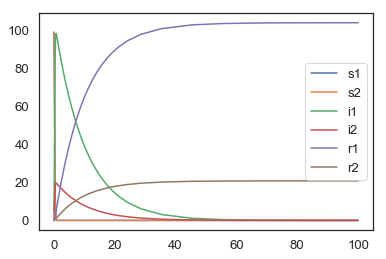

In [5]:
#Plot the results
results.plot()

We decided that using Euler's method would be better for our model's needs, especially when incorporating the travel between countries. We'll come back to the ODE solver if possible when our data is established.

In [81]:
def update_func(state, t, system):
    '''
    Uses Euler's method to estimate the next value.
    
    input:
        state = State object with current State values
        t = not used, but included for consistency
        system = System object with system variables
    
    output:
        new State variable with updated State values
    '''
    unpack(system)
    s1, s2, i1, i2, r1, r2 = state
    infectedPeopleMoved = 0
    if (flip(.3) and i2>=0):
        infectedPeopleMoved = .000001
    elif(i1>0):
        infectedPeopleMoved = -.000001
   
    ds1dt = -(infectionRate1*s1*i1)
    ds2dt = -(infectionRate2*s2*i2)
    di1dt = (infectionRate1*s1*i1)-i1*recoveryRate1 
    di2dt = (infectionRate2*s2*i2)-i2*recoveryRate2 
    dr1dt = i1*recoveryRate1
    dr2dt = i2*recoveryRate2
    s1   += ds1dt*dt 
    s2   += ds2dt*dt
    i1   += di1dt*dt + infectedPeopleMoved*dt
    i2   += di2dt*dt - infectedPeopleMoved*dt
    r1   += dr1dt*dt
    r2   += dr2dt*dt
    
    return State(s1=s1,s2=s2,i1=i1,i2=i2,r1=r1,r2=r2)
    

Here we used the run_simulation function previously defined in notebooks.

In [82]:
def run_simulation(state, system):
    '''
    Runs a simulation
    input:
        state = State variable
        system = System variable
    output: 
        TimeFrame of all data points generated
    '''
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(system.t0,system.t_end,dt):
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    return frame

### Results:

Here we run the simulation and graph the resulting TimeFrame.

In [78]:
results = run_simulation(init, system)

,s1,s2,i1,i2,r1,r2
1.00,99,99,5,0,0,0
1.01,98.9505,99,5.047,1e-08,0.0025,0
1.02,98.9006,99,5.09442,9.4e-11,0.0050235,5e-12
1.03,98.8502,99,5.14225,1.00949e-08,0.00757071,5.047e-12
1.04,98.7993,99,5.19051,1.89776e-10,0.0101418,1.00944e-11
1.05,98.7481,99,5.2392,1.01916e-08,0.0127371,1.01893e-11
1.06,98.6963,99,5.28832,2.02874e-08,0.0153567,1.52851e-11
1.07,98.6441,99,5.33787,3.04781e-08,0.0180009,2.54288e-11
1.08,98.5915,99,5.38785,4.07646e-08,0.0206698,4.06678e-11
1.09,98.5384,99,5.43828,3.11477e-08,0.0233637,6.10501e-11


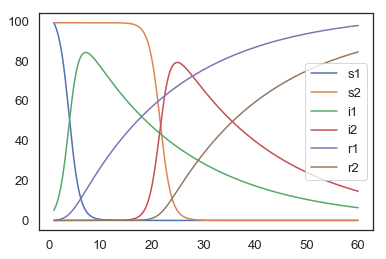

In [79]:
results.plot()

### Results:
Coming soon!

### Interpretation:
Coming soon!

### Ignore everything below this please.

In [126]:
def slope_func2(state, t, system):
    '''
    finds dx/dt for each stock and returns them
    inputs:
        state current state variable at time t
        t = current time
        system = model's system variable
    output:
        updated rates
        
    '''
    unpack(system)
    s1, s2, i1, i2, r1, r2 = state
    ## infectedPeopleMoved= movementRate*np.random.randn()
    infectedPeopleMoved = 0
    if (flip(.3) and i2>=0):
        infectedPeopleMoved = 1
    elif(i1>0):
        infectedPeopleMoved = -1
   
    ds1dt = -(infectionRate1*s1*i1)
    ds2dt = -(infectionRate1*s1*i1)
    di1dt = (infectionRate1*s1*i1) - i1*recoveryRate1 + infectedPeopleMoved
    di2dt = (infectionRate2*s2*i2) - i2*recoveryRate2 - infectedPeopleMoved
    dr1dt = i1*recoveryRate1
    dr2dt = i2*recoveryRate2
    return ds1dt, ds2dt, di1dt, di2dt, dr1dt, dr2dt

In [130]:
results2,details=run_ode_solver(system, slope_func2, min_step=.1, max_step=.1)

C:\Miniconda3\lib\site-packages\scipy\integrate\_ivp\common.py:32: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


In [131]:
details

,values
sol,None
t_events,[]
nfev,135560
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


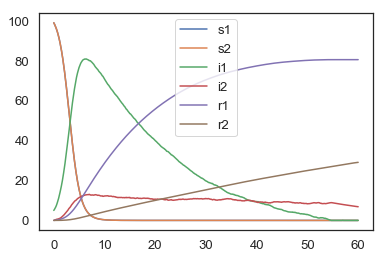

In [132]:
results2.plot()

In [133]:
results2

,s1,s2,i1,i2,r1,r2
0.000000,99.000000,99.000000,5.000000,0.000000,0.000000,0.000000e+00
0.000083,98.999587,98.999587,5.000277,0.000115,0.000021,1.988438e-10
0.000151,98.999252,98.999252,5.000527,0.000183,0.000038,7.045210e-10
0.000230,98.998861,98.998861,5.000819,0.000262,0.000058,1.582053e-09
0.000845,98.995815,98.995815,5.003097,0.000878,0.000211,1.910990e-08
0.000925,98.995418,98.995418,5.003394,0.000958,0.000231,2.278653e-08
0.000986,98.995117,98.995117,5.003630,0.001008,0.000247,2.575561e-08
0.001096,98.994572,98.994572,5.004180,0.000974,0.000274,3.143929e-08
0.001179,98.994162,98.994162,5.004578,0.000966,0.000295,3.551556e-08
0.001288,98.993620,98.993620,5.005102,0.000957,0.000322,4.061889e-08
